# **绘制频谱图，看见声音的成分**

**参考：**

+ [Audio Handling Basics: Process Audio Files In Command-Line or Python](https://hackernoon.com/audio-handling-basics-how-to-process-audio-files-using-python-cli-jo283u3y)

+ [Frequency spectrum using FMOD and UE4](https://www.parallelcube.com/2018/03/10/frequency-spectrum-using-fmod-and-ue4/)

+ [Frequency spectrum of sound using PyAudio, NumPy, and Matplotlib](https://blog.yjl.im/2012/11/frequency-spectrum-of-sound-using.html)

**关键：理解傅立叶变换，fft 与 dft**
&emsp;


In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
plt.style.use('ggplot')

In [2]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
plt.style.use('ggplot')

&emsp;

### **以 1 小段音乐（0.2s）为例做分析**

In [3]:
songpath = "audio/seg.wav"
ipd.Audio(songpath)


&emsp;

### **使用 librosa 按指定参数处理音乐、绘制波形图**

**采样率：sr = 44100**   
**声道数：单声道**

In [4]:
# librosa 默认 sr=22050，所以下面要指定按 44100 采样，将声道设为单声道 （mono=True）
# x 就是按 sr 采样时，每一个时间点上声音的强度大小，是一个时间序列
x, sr = librosa.load('audio/seg.wav', sr=44100, mono=True)   

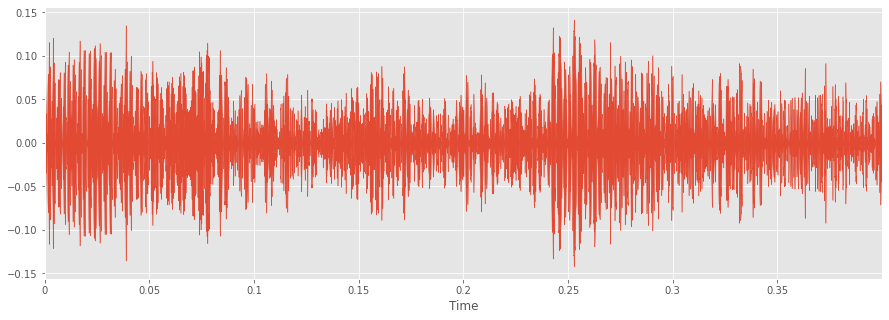

In [5]:
plt.figure(figsize=(15,5))
librosa.display.waveplot(x)

&emsp;

### **经傅立叶转换绘制音乐的频谱图**

In [7]:
t = 0.2
n_sample = int(sr * t)


In [17]:
x_w = x*np.hanning(len(x))
X = np.abs(np.fft.fft(x_w))[0:int(n_sample/2)]/n_sample

#X = np.abs(np.fft.fft(x)[0:int(n_sample/2)])

In [21]:
X*n_sample

array([1.22315474e-01, 1.89914918e-01, 3.21469478e-01, ...,
       3.60629051e-04, 9.53830823e-05, 1.49958377e-04])

In [10]:
f_vec = np.arange(n_sample/2)*sr/8820

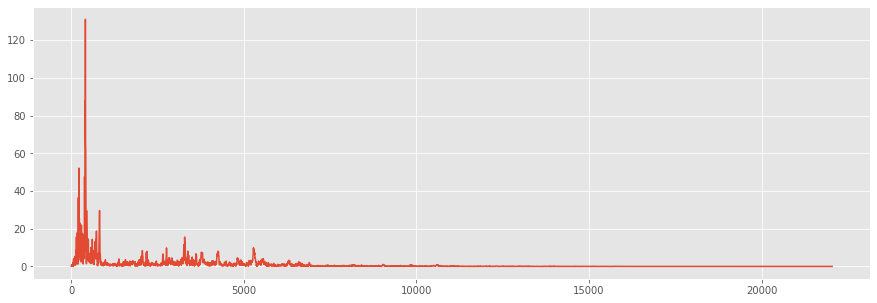

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(f_vec,X)

</br>
</br>

### **进一步对频率做合并以 bar 图呈现**
**线性等距频率区间**

In [12]:
# 将 4410 个频率等距分为 30 组呈现
num_bins = 30
step = 147  # 4410/30
f_vec1 = f_vec[0::step].astype('str')
X1 = np.mean(X.reshape(-1,step),axis=1)

<BarContainer object of 30 artists>

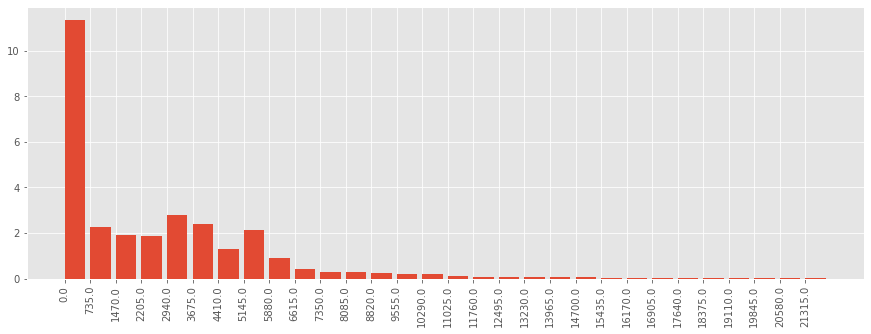

In [13]:
fig1, ax1 = plt.subplots(figsize=(15,5))
for tick1 in ax1.get_xticklabels():
    tick1.set_rotation(90)
ax1.bar(f_vec1, X1, align='edge')      # 30个 bar（bin）

</br>
</br>

**对数频率区间**

从上图可以看出，低频率的声波在音乐的构成中占更大的比重，因此完全等距的将频率分组并不适合体现音乐的构成，采用 _**对数分布**_ 是更优的选择。

人耳一般能听到 **20 Hz-20000 Hz** 的声音，数字化的音频为了覆盖整个频率范围，根据 [Nyquist Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)，采样率一般是 **44100 Hz**（20000 Hz 的 2 倍）。音乐中，如果两个音符间隔一个 **[八度](https://en.wikipedia.org/wiki/Octave)**，则高八度音符的频率是低八度的 **2** 倍。由此，可以将 0 - 22050 Hz（44100 的一半）按照音乐中的八度关系，分为 12 组：

11025 Hz - 22050 Hz      
5512 Hz  - 11025 Hz       
2756 Hz  - 5512 Hz   
1378 Hz  - 2756 Hz   
689 Hz   - 1378 Hz   
344 Hz   - 689 Hz   
172 Hz   - 344 Hz   
86 Hz    - 172 Hz   
43 Hz    - 86 Hz   
21 Hz    - 43 Hz   
10 Hz    - 21 Hz   
0 Hz     - 10 Hz  

下面就是按照以上思路对频率分组的

In [14]:
end_index = []

for i in np.arange(12):    
    end_index.append(int((n_sample/2)/2**i))
    
end_index.reverse()


In [20]:
start_index

[0, 3, 5, 9, 18, 35, 69, 138, 276, 552, 1103, 2206]

In [21]:
end_index

[2, 4, 8, 17, 34, 68, 137, 275, 551, 1102, 2205, 4410]

In [15]:
# end_index 就是每个频率区间最大值，下面是要找到每个频率区间的起始值（最小值）
# 这里上一区间的最大值与下一区间的最小值不重合

start_index = [0]
for i in end_index[:-1]:
    start_index.append(i+1)
    

In [16]:
X2 = []
for i in np.arange(12):
    XX = np.mean(X[start_index[i]:end_index[i]])
    X2.append(XX)
    i=i+1
    

In [125]:
label =  ["%.2f" % number for number in start_index]

<BarContainer object of 12 artists>

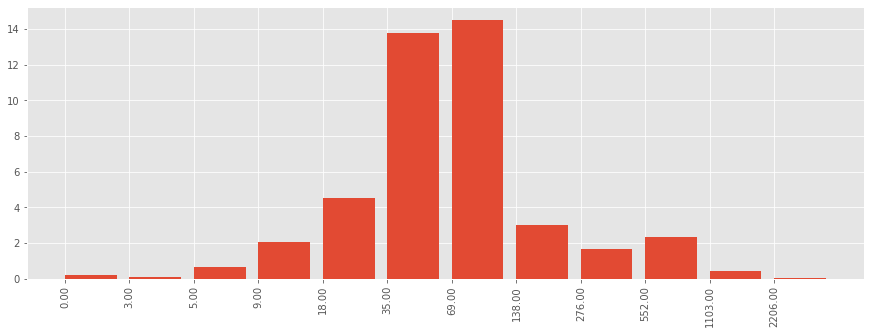

In [126]:
fig2, ax2 = plt.subplots(figsize=(15,5))
for tick2 in ax2.get_xticklabels():
    tick2.set_rotation(90)
ax2.bar(label,X2, align='edge')